# Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
!head train.csv

id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0
5,0,1,1,T,N,Blue,Polygon,Lion,Costa Rica,Oboe,46cab09da,29a854620,ff5b35098,b7e6f8e6f,51e27c16d,1,Novice,Freezing,j,E,PZ,2,2,0
6,0,1,1,T,N,Green,Trapezoid,Cat,China,Piano,be5592604,3393a0f78,c6587685d,0

In [3]:
# Read the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

y_train = df_train.loc[:, "target"]
df_train.drop(columns="target", inplace=True)

# Length of training set
N_train = len(df_train)

# We concatentate the training set and test set together to simplify
# the encoding process. We will split them back in the end of this
# preprocessing script.
# The order of data is not lost since there is a unique id column.
combine = pd.concat((df_train, df_test)).reset_index(drop=True)

del df_train, df_test
print(combine.shape)

(500000, 24)


## Check NA for both train set and test set

In [4]:
combine.isna().sum().sum()

0

Conclusion: We see that there is no NA's in the data, so we may proceed with the data wrangling process.

In [5]:
# We keep track of which columns are one-hot encoded, and which ones are not
# TODO
data_columns = []
one_hot_columns = []

## Binary features

In [6]:
# For columns bin_3, bin_4, we convert T and F to 1 and 0 respectively.
combine.loc[:, "bin_3"] = (combine.loc[:, "bin_3"] == "T").astype(int)
combine.loc[:, "bin_4"] = (combine.loc[:, "bin_4"] == "Y").astype(int)

In [7]:
combine.loc[:, "bin_0": "bin_4"].head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0,0,0,1,1
1,0,1,0,1,1
2,0,0,0,0,1
3,0,1,0,0,1
4,0,0,0,0,0


In [8]:
bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
data_columns += bin_features
one_hot_columns += bin_features

## Nominal Features

We see from simple EDA that nom_0 ... nom_4 are low cardinal features. We use both label encoding and one hot encoding on them, and choose only the appropriate set of features needed by the classifier in the training process.

CART (e.g. Decision Tree, Random Forest, XGB) label encoding

Others (e.g. Logistic Regression) one-hot encoding

In [9]:
nominal_low_card = ["nom_%d" % i for i in range(0, 5)]

In [10]:
# Generate one hot encoding columns
nom_dummy = pd.get_dummies(combine,
        columns=nominal_low_card, drop_first=True)
combine = pd.concat(
    (combine, nom_dummy.loc[:, "nom_0_Green": "nom_4_Theremin"]),
    axis="columns"
)

In [11]:
combine.shape

(500000, 44)

In [12]:
# Replace the original columns Label encoding with label encoding
for col_name in nominal_low_card:
    labels = combine.loc[:, col_name].unique()
    repl_dict = dict(zip(labels, range(len(labels))))
    combine.loc[:, col_name].replace(repl_dict, inplace=True)

In [13]:
# Check that label encoding works correctly
combine.loc[:, nominal_low_card].nunique()

nom_0    3
nom_1    6
nom_2    6
nom_3    6
nom_4    4
dtype: int64

In [14]:
# Appending low cardinal nominal columns
dummy_columns = list(
    nom_dummy.loc[:,
    "nom_0_Green": "nom_4_Theremin"].columns
)

data_columns += nominal_low_card
one_hot_columns += dummy_columns

For columns nom_5 to nom_9, we treat them as hexademical numbers (hashing as label encoding), and then we calculate the frequency and append this as a feature. Notice we cannot do one-hot encoding on them since this makes the matrix way too sparse for anything meaningful.

In [15]:
# This jusifies dropping them from one-hot encoding
nominal_high_card = ["nom_%d" % i for i in range(5, 10)]
combine.loc[:, nominal_high_card].nunique()

nom_5      222
nom_6      522
nom_7     1220
nom_8     2219
nom_9    12068
dtype: int64

In [16]:
# Label encoding via hashing and frequency encoding
# In this case we just convert these "hex-like" strings
# to large positive integers.

import functools
base16 = functools.partial(int, base=16)

for i in range(5, 10):
    col_name = "nom_%d" % i
    freq_col_name = "nom_%d_freq" % i
    
    nom_hex = combine.loc[:, col_name].astype(str).apply(base16)
    freq = nom_hex.value_counts() / len(combine)
    
    # TODO: pd.Series.replace causing OOM's
    # switching to manual lookup via df.apply

    combine.loc[:, freq_col_name] = nom_hex.apply(lambda x: freq[x])
    combine.loc[:, col_name] = nom_hex

In [17]:
# Let's check the results
combine.loc[:, "nom_5":"nom_9"].head()

,nom_5,nom_6,nom_7,nom_8,nom_9
0,21727636431,15772387348,28175946729,52488569003,12696894801
1,48239551952,67590492097,15952860690,20628767313,66635263009
2,13526359269,2452503736,44731659559,59756902020,46816824784
3,64728884626,21700990058,63461013227,20097444713,35015036273
4,24443727061,8557928957,1306182334,54563352949,47618683559


In [18]:
combine.loc[:, "nom_5_freq":"nom_9_freq"].head()

,nom_5_freq,nom_6_freq,nom_7_freq,nom_8_freq,nom_9_freq
0,0.008624,0.003752,0.000820,0.000978,0.000064
1,0.002608,0.002736,0.000924,0.000358,0.000046
2,0.008518,0.003868,0.001600,0.000878,0.000100
3,0.003256,0.003874,0.001500,0.000714,0.000146
4,0.006602,0.003858,0.001520,0.000690,0.000126


In [19]:
# Appending high cardinal columns
hc = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
hc_freq = ['nom_5_freq', 'nom_6_freq',
    'nom_7_freq', 'nom_8_freq', 'nom_9_freq']

data_columns += hc
one_hot_columns += hc_freq

# We also append the frequency encoding to the cart methods
data_columns += hc_freq

## Ordinal features

In [20]:
combine.loc[:, "ord_0": "ord_5"].head()

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
0,2,Grandmaster,Cold,h,D,kr
1,1,Grandmaster,Hot,a,A,bF
2,1,Expert,Lava Hot,h,R,Jc
3,1,Grandmaster,Boiling Hot,i,D,kW
4,1,Grandmaster,Freezing,a,R,qP


In [21]:
# Some simple inspection on ord_0
combine.loc[:, "ord_0"].unique()

array([2, 1, 3], dtype=int64)

In [22]:
# For ord_0, we rename 1, 2, 3 to 0, 1, 2 just for cohesiveness
combine.loc[:, "ord_0"] -= 1

In [23]:
# We see that the items in ord_1 have their own meanings. We replace the values with their natural ordering.
combine.loc[:, "ord_1"].unique()

array(['Grandmaster', 'Expert', 'Novice', 'Contributor', 'Master'],
      dtype=object)

In [24]:
repl_dict = {
    "Novice": 0,
    "Contributor": 1,
    "Expert": 2,
    "Master": 3,
    "Grandmaster": 4
}

combine.loc[:, "ord_1"].replace(repl_dict, inplace=True)

In [25]:
# Do the same for ord_2
combine.loc[:, "ord_2"].unique()

array(['Cold', 'Hot', 'Lava Hot', 'Boiling Hot', 'Freezing', 'Warm'],
      dtype=object)

In [26]:
repl_dict = {
    "Freezing": 0,
    "Cold": 1,
    "Warm": 2,
    "Hot":3,
    "Boiling Hot": 4,
    "Lava Hot":5
}

combine.loc[:, "ord_2"].replace(repl_dict, inplace=True)

In [27]:
# ord_3 consist of some alphabetical letters. We replace them with ascii codes.
combine.loc[:, "ord_3"].unique()

array(['h', 'a', 'i', 'j', 'g', 'e', 'd', 'b', 'k', 'f', 'l', 'n', 'o',
       'c', 'm'], dtype=object)

In [28]:
combine.loc[:, "ord_3"] = combine.loc[:, "ord_3"].apply(ord) - ord("a")

In [29]:
# Do the same for ord_4.
combine.loc[:, "ord_4"].unique()

array(['D', 'A', 'R', 'E', 'P', 'K', 'V', 'Q', 'Z', 'L', 'F', 'T', 'U',
       'S', 'Y', 'B', 'H', 'J', 'N', 'G', 'W', 'I', 'O', 'C', 'X', 'M'],
      dtype=object)

In [30]:
combine.loc[:, "ord_4"] = combine.loc[:, "ord_4"].apply(ord) - ord("A")

In [31]:
# For ord_5, we know it should be sorted in lexicographic order. We take its index in the sorted values.
symbols = sorted(combine.loc[:, "ord_5"].unique())
symbols[:5]

['AP', 'Ai', 'Aj', 'BA', 'BE']

In [32]:
combine.loc[:, "ord_5"] = combine.loc[:, "ord_5"].apply(lambda x: symbols.index(x))
combine.loc[:, "ord_5"].head()

0    136
1     93
2     31
3    134
4    158
Name: ord_5, dtype: int64

We would like to inspect the impact of these ordinal variables.

Take ord_5 as an example.

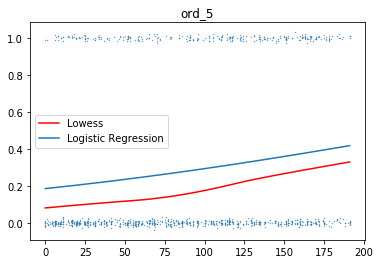

In [33]:
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
lowess = statsmodels.nonparametric.smoothers_lowess.lowess

# Suppress FutureWarning resulted from sm.add_constant + pd.DataFrame
# without converting to numpy array
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set random seed
np.random.seed(42)

sample_size = 1000
choice = np.random.choice(N_train, size=sample_size, replace=False)
X = combine.loc[choice, "ord_5"]
y = y_train.loc[choice]

# Sort X, y pairs by X ascending to plot properly
X, y = list(zip(*sorted(zip(X, y), key=(lambda x: x[0]))))

X_const = sm.add_constant(X, has_constant="add")

y_low = lowess(y, X)

lr = sm.GLM(y, X_const, family=sm.families.Binomial()).fit()
y_lr = lr.predict()

# Jitter y little bit so se can see clearer
y_noise = y + np.random.normal(0, 0.01, sample_size)

plt.scatter(X, y_noise, s=0.1)
plt.plot(y_low[:, 0], y_low[:, 1], 'r', label="Lowess")
plt.plot(X, y_lr, label="Logistic Regression")
plt.legend()
plt.title("ord_5")

del sample_size, choice, X, y, X_const, y_low, lr, y_lr, y_noise

Conclusion: indeed, we cannot treat these as quantities; label encoding is not enough, we need to one-hot encode them for the non-CART based methods.

In [34]:
# One hot encoding
ord_columns = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']
ord_dummy = pd.get_dummies(combine,
        columns=ord_columns, drop_first=True)

ord_dummy_columns = list(ord_dummy.loc[:, 'ord_0_1': 'ord_5_191'].columns)
combine = pd.concat(
    (combine, ord_dummy.loc[:, ord_dummy_columns]),
    axis="columns"
)

In [35]:
# Now append the ord columns
data_columns += ord_columns
one_hot_columns += ord_dummy_columns

## Cyclic features

For cyclical features, we transform this feature onto a unit circle via sin(), cos(), then drop the original ones.

In [36]:
def get_cyclic_feature(col: pd.Series, T):
    interval = 2 * np.pi / T
    phase = col * interval
    return np.sin(phase), np.cos(phase)

In [37]:
# day and month are cyclical, so we use the sin/cos trick on them.
# day means day of the week
combine.loc[:, "day"].unique()

array([2, 7, 5, 4, 3, 1, 6], dtype=int64)

In [38]:
day_sin, day_cos = get_cyclic_feature(combine.loc[:, "day"], 7)
combine.loc[:, "day_sin"] = day_sin
combine.loc[:, "day_cos"] = day_cos

In [39]:
combine.drop(columns="day", inplace=True)

In [40]:
# Do the same for month
combine.loc[:, "month"].unique()

array([ 2,  8,  1,  4, 10,  3,  7,  9, 12, 11,  5,  6], dtype=int64)

In [41]:
month_sin, month_cos = get_cyclic_feature(combine.loc[:, "month"], 12)
combine.loc[:, "month_sin"] = month_sin
combine.loc[:, "month_cos"] = month_cos

In [42]:
combine.drop(columns="month", inplace=True)

In [43]:
cyc = ["day_sin", "day_cos", "month_sin", "month_cos"]
data_columns += cyc
one_hot_columns += cyc

## Convert to integers and save as file 

In [44]:
print(len(data_columns), len(one_hot_columns))

30 275


In [45]:
combine.shape

(500000, 292)

In [46]:
# Let's split the dataset into the original training and test set,
# and put back the target in the training set
X_train = combine[:N_train]
X_test = combine[N_train:]


In [47]:
import h5py

X_train.to_hdf("cat.hdf5", "train")
X_test.to_hdf("cat.hdf5", "test")

y_train.to_hdf("cat.hdf5", "train_target")

In [48]:
# Metadata: column names for the label encoding and one-hot encoding
with h5py.File("cat.hdf5", "a") as f:
    f.create_dataset("data_columns", data=np.array(data_columns, dtype='S'))
    f.create_dataset("one_hot_columns", data=np.array(one_hot_columns, dtype='S'))